<a href="https://colab.research.google.com/github/Diksha-kumari-singh/ERA5-Rainfall-Prediction-Model/blob/main/weather_prediction_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Null values in each column:
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64
Unique weather classes: ['drizzle' 'rain' 'sun' 'snow' 'fog']


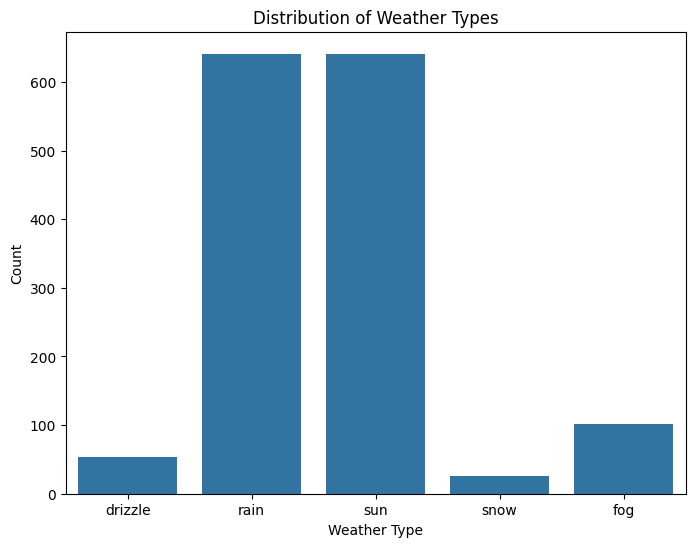

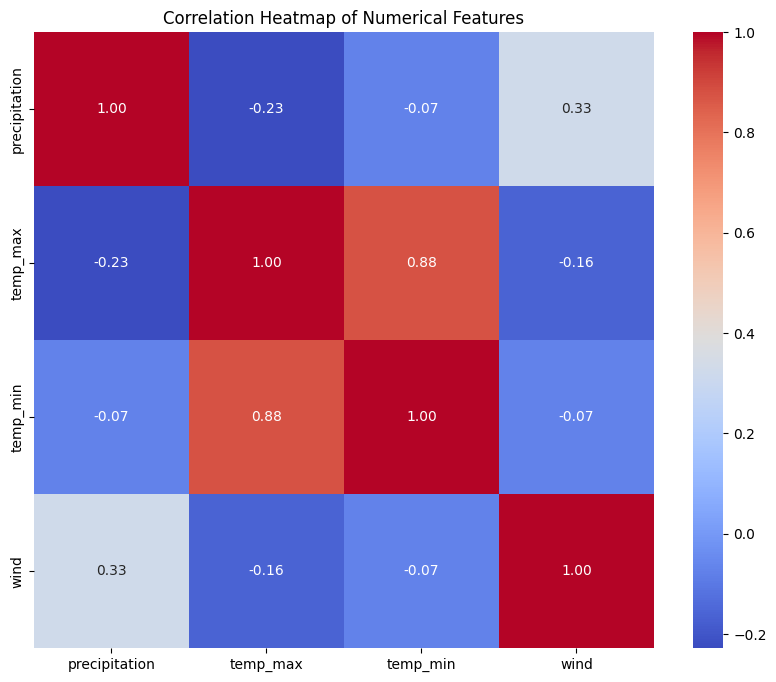

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Load the dataset
# Replace 'path/to/your/file.csv' with the actual path to your Seattle Weather dataset.
df = pd.read_csv('/content/seattle-weather.csv')

# Check for null values
print("Null values in each column:")
print(df.isnull().sum())

# Get the unique classes in the target variable
unique_weather = df['weather'].unique()
print(f"Unique weather classes: {unique_weather}")

# Visualize the distribution of the 'weather' class
plt.figure(figsize=(8, 6))
sns.countplot(x='weather', data=df)
plt.title('Distribution of Weather Types')
plt.xlabel('Weather Type')
plt.ylabel('Count')
plt.show()

# Visualize the correlation matrix of numerical features
numerical_cols = ['precipitation', 'temp_max', 'temp_min', 'wind']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [3]:
# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Extract new features: year, month, and day
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Drop original 'date' and 'year' columns
df = df.drop(columns=['date', 'year'])

In [4]:
# Separate features (X) and target (y)
X = df.drop(columns=['weather'])
y = df['weather']

# Apply SMOTEENN to handle class imbalance
print("Original dataset shape:", y.value_counts())

smoteenn = SMOTEENN(random_state=42)
X_res, y_res = smoteenn.fit_resample(X, y)

print("Resampled dataset shape:", y_res.value_counts())

Original dataset shape: weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64
Resampled dataset shape: weather
snow       635
drizzle    517
fog        492
rain       345
sun        185
Name: count, dtype: int64


In [5]:
# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y_res)

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_encoded, test_size=0.2, random_state=42)

In [6]:
# Initialize and train the individual models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Dictionary to store results
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)

    print(f"{name} Accuracy: {accuracy:.4f}")

# Display initial results
initial_results_df = pd.DataFrame(results)
print("\nInitial Model Performance:")
print(initial_results_df.sort_values(by='Accuracy', ascending=False))

Logistic Regression Accuracy: 0.7586
Decision Tree Accuracy: 0.9218
SVM Accuracy: 0.7701
Random Forest Accuracy: 0.9586
KNN Accuracy: 0.9287
AdaBoost Accuracy: 0.4736


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:59:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9609

Initial Model Performance:
                 Model  Accuracy  Precision    Recall  F1-Score
6              XGBoost  0.960920   0.961662  0.960920  0.960774
3        Random Forest  0.958621   0.961163  0.958621  0.956935
4                  KNN  0.928736   0.932615  0.928736  0.927517
1        Decision Tree  0.921839   0.926149  0.921839  0.919236
2                  SVM  0.770115   0.808661  0.770115  0.761351
0  Logistic Regression  0.758621   0.766114  0.758621  0.758404
5             AdaBoost  0.473563   0.547511  0.473563  0.469189


In [7]:
# Hyperparameter tuning for XGBoost using GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# Initialize GridSearchCV with XGBoost
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Evaluate the tuned model on the test set
tuned_xgb_model = grid_search.best_estimator_
y_pred_tuned_xgb = tuned_xgb_model.predict(X_test)
tuned_xgb_accuracy = accuracy_score(y_test, y_pred_tuned_xgb)
print(f"Tuned XGBoost Test Accuracy: {tuned_xgb_accuracy:.4f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:02:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Best cross-validation accuracy:  0.9384719988882934
Tuned XGBoost Test Accuracy: 0.9609


In [8]:
# Initialize base models for the voting classifier
clf1 = RandomForestClassifier(random_state=42)
clf2 = KNeighborsClassifier()
clf3 = tuned_xgb_model # The best estimator from GridSearchCV

# Create a soft voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf', clf1), ('knn', clf2), ('xgb', clf3)],
    voting='soft'
)

# Train and evaluate the voting classifier
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:02:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Voting Classifier Accuracy: 0.9747


In [9]:
# Initialize base models and a meta-model for the stacking classifier
base_models = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
]

# Define the meta-model (final estimator)
meta_model = LogisticRegression(max_iter=1000)

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# Train and evaluate the stacking classifier
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Classifier Accuracy: {stacking_accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:03:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:03:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:03:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:03:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:03:50] WARNING: /w

Stacking Classifier Accuracy: 0.9862


--- Logistic Regression Results ---
Accuracy: 0.7586
Precision: 0.7661
Recall: 0.7586
F1-Score: 0.7584
--------------------
--- Decision Tree Results ---
Accuracy: 0.9218
Precision: 0.9261
Recall: 0.9218
F1-Score: 0.9192
--------------------
--- SVM Results ---
Accuracy: 0.7701
Precision: 0.8087
Recall: 0.7701
F1-Score: 0.7614
--------------------
--- Random Forest Results ---
Accuracy: 0.9586
Precision: 0.9612
Recall: 0.9586
F1-Score: 0.9569
--------------------
--- KNN Results ---
Accuracy: 0.9287
Precision: 0.9326
Recall: 0.9287
F1-Score: 0.9275
--------------------
--- AdaBoost Results ---
Accuracy: 0.4736
Precision: 0.5475
Recall: 0.4736
F1-Score: 0.4692
--------------------
--- XGBoost (Tuned) Results ---
Accuracy: 0.9609
Precision: 0.9618
Recall: 0.9609
F1-Score: 0.9604
--------------------
--- Ensemble (Voting) Results ---
Accuracy: 0.9747
Precision: 0.9756
Recall: 0.9747
F1-Score: 0.9744
--------------------
--- Ensemble (Stacking) Results ---
Accuracy: 0.9862
Precision: 0.986

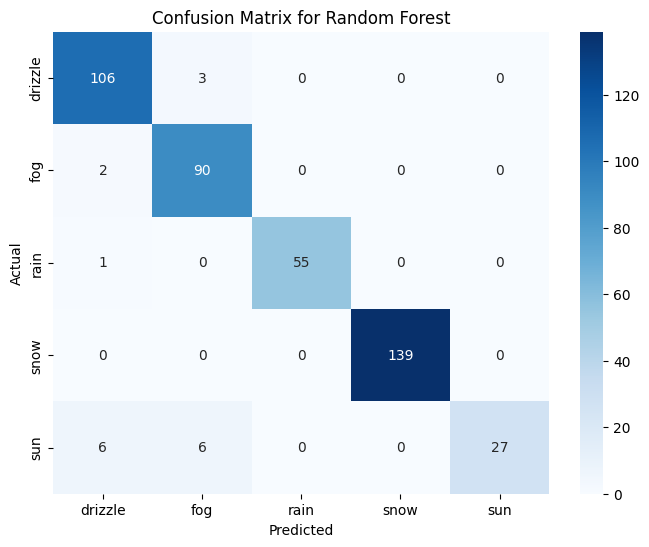

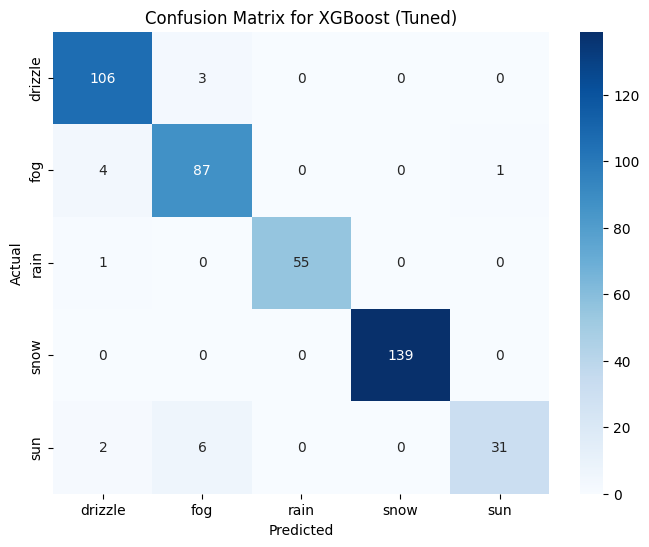

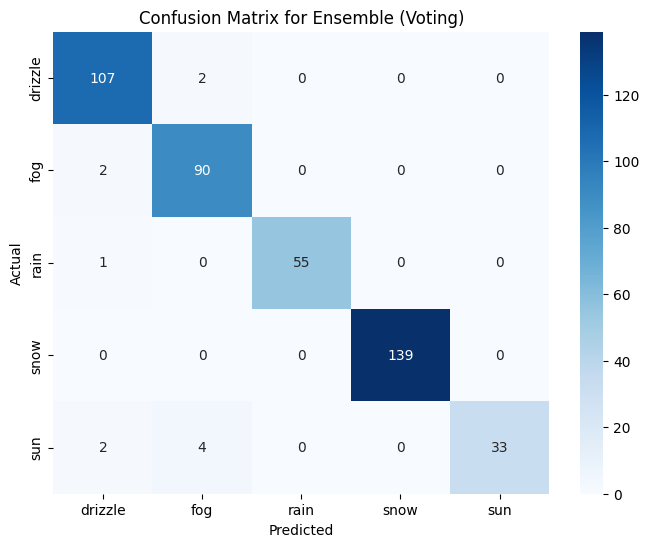

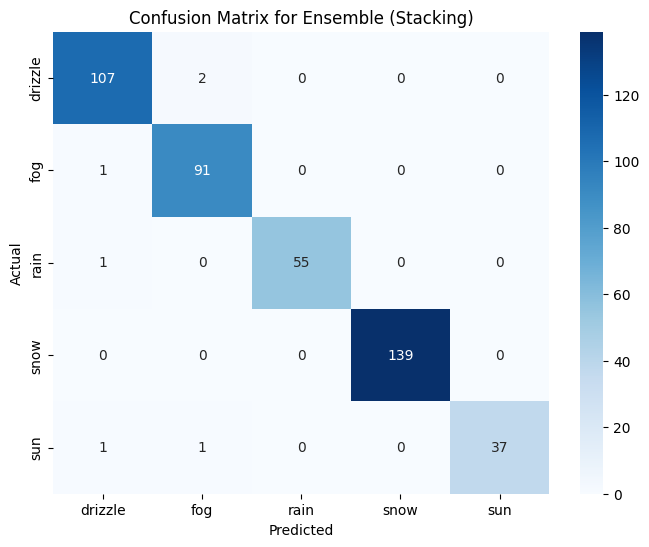

In [10]:
# Re-evaluate all models for a final comparison
all_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost (Tuned)': tuned_xgb_model,
    'Ensemble (Voting)': voting_clf,
    'Ensemble (Stacking)': stacking_clf
}

# Dictionary to store final comparative results
final_results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
confusion_matrices = {}

for name, model in all_models.items():
    if name not in ['Ensemble (Voting)', 'Ensemble (Stacking)', 'XGBoost (Tuned)']:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    final_results['Model'].append(name)
    final_results['Accuracy'].append(accuracy)
    final_results['Precision'].append(precision)
    final_results['Recall'].append(recall)
    final_results['F1-Score'].append(f1)

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    print(f"--- {name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 20)

# Create the final comparative analysis table
final_results_df = pd.DataFrame(final_results)
print("\nFinal Comparative Analysis Table:")
print(final_results_df.sort_values(by='Accuracy', ascending=False))

# Plot confusion matrices for top models
for name, cm in confusion_matrices.items():
    if name in ['Random Forest', 'XGBoost (Tuned)', 'Ensemble (Voting)', 'Ensemble (Stacking)']:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()